In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

## Load scan file

In [2]:
pgroup='p21148'
runnumber = 9
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
if scan.parameters['scan_name'] != 'dummy':
    if scan.parameters['units'] == ['fs']:
        Timezero_mm = get_timezero_NBS(jsonfile)
        scanvar = scan.readbacks - mm2fs(Timezero_mm, 0)
    else: 
        scanvar = scan.readbacks
    print ('Scan contains {} step(s), scanvar goes from {:.2f} to {:.2f} {}'.format(len(scan), scanvar[0], scanvar[-1], scan.parameters['units'][0]))
else:
    print ('No motors moved')

run: 0009
/sf/alvra/data/p21148/raw/run0009-test_vonHamos_scan/meta/scan.json
Scan contains 6 step(s), scanvar goes from -48.70 to 200.81 fs


In [3]:
threshold_low = 0
threshold_high = 10

Timezero_mm = 100.02694

channels_list = []

reducedir='../Claudio/Reduced_XES_timescans/'
saveflag = False

TT = TT_PSEN126
Timezero_mm = 100.02694
channel_delay_motor = channel_delay_topas

#####################################################

import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:        
    Timezero_mm = Timezero_mm
    flag = False
    
Delays_fs_scan, Delays_corr_scan, spectra_shots_on, spectra_shots_off, ROIs, Delay_fs, Delay_mm, meta = \
XES_delayscan_TT_ROIs(scan, channels_list, TT, channel_delay_motor, Timezero_mm, threshold_low, threshold_high)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

if scan.parameters['units'] == ['nS']:
    Delay_fs = scan.values
#    Delay_fs = Delay_fs - 0.17
else:
    Delay_fs = scan.values
    Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
run_name = jsonfile.split('/')[-3]
if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_data_XES_timescans_ROIs(reducedir, run_name, spectra_on, spectra_off, ROIs, meta)    

Processing: run0009-test_vonHamos_scan
Step 6 of 6: Processing acq0006

--------------------------------------------------------------------------------

JF02T09V03:ROI_Cr2DW                     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_Cr2UP                     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet                  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 10 / 10 -> 0% incomplete

--

In [4]:
s_all_on = {}
s_all_off = {}
for key in ROIs:
    spectra_all_on=[]
    spectra_all_off=[]
    for index_step in range(len(scan)):
        spectra_all_on.extend(spectra_shots_on[index_step][key])
        spectra_all_off.extend(spectra_shots_on[index_step][key])
    s_all_on[key] = spectra_all_on
    s_all_off[key] = spectra_all_off

In [26]:
binsize = 10

binList = np.arange(Delays_fs_scan[0] - 100, Delays_fs_scan[-1] + 100, binsize)
bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(Delays_fs_scan[0] -100 + binsize/2, Delays_fs_scan[-1] + 100 - binsize/2, binsize)

s_rebin_on = {}
s_rebin_off = {}
for j,key in enumerate(ROIs):
    temp_s_on  = np.array(s_all_on[key])
    temp_s_off = np.array(s_all_off[key])
    spec_rebin_on  = np.zeros((len(bin_centres), np.array(meta[key+'-roi'])[1][1]-np.array(meta[key+'-roi'])[1][0]))
    spec_rebin_off = np.zeros((len(bin_centres), np.array(meta[key+'-roi'])[1][1]-np.array(meta[key+'-roi'])[1][0]))
    
    for i in range(len(bin_centres)):
        cond1 = Delays_corr_scan > binList[i]
        cond2 = Delays_corr_scan < binList[i+1]

        idx = np.where(cond1*cond2)[0]

        Delay_fs_TT[i] = np.average(Delays_corr_scan[idx])
        
        spec_rebin_on[i]  = np.average(temp_s_on[idx,:], axis=0)
        spec_rebin_off[i] = np.average(temp_s_off[idx,:], axis=0)
        
    s_rebin_on[key]  = spec_rebin_on
    s_rebin_off[key] = spec_rebin_off

(44, 600)
(44,)
(600,)


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

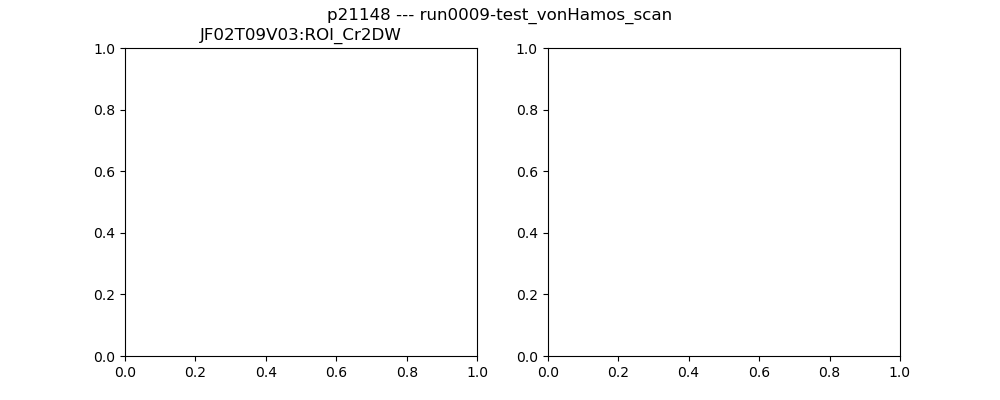

In [23]:
energy_calib = False

m = -5.430862659608205
b = 16537.553363439678

bin_ = 1

vmin = None
vmax = None

################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs), figsize=(10,4))
plt.suptitle(titlestring)
for i, (key, ax) in enumerate(zip(ROIs, axs.flatten())):
    matrix_off = s_rebin_on[key]
        
    yaxis = np.arange(np.array(meta[key+'-roi']).flatten()[-2], np.array(meta[key+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        y_axis_rebin = (y_axis_rebin-b)/m
        ylabel = 'Emission energy (eV)'
        
    plt.sca(ax)
    plt.title(key)
    plt.pcolormesh(Delay_fs_TT, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    #plt.plot(Delay_fs, np.transpose(np.asarray(matrix_off_rebin)).sum(axis=0))
    plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.grid()
    plt.xlabel('Delay ({})'.format(scan.parameters['units'][0]))
plt.tight_layout()

In [19]:
def rebin2D(arr, axis, bin_):
    arr = np.array(arr)
    arr_new=[]
    if axis == 1:
        arr=arr.T
    for index in range(len(arr)):
        cut=arr[index]
        new=bin_sum(cut,bin_)
        arr_new.append(new)
    arr_new=np.array(arr_new)
    if axis == 1:
        arr_new=arr_new.T
    return arr_new

In [20]:
def plot_tool_2D(matrix_ON, matrix_OFF, axis, x_axis, bin_):
    
    matrix_on_rebin  = rebin2D(matrix_ON, axis, bin_)
    matrix_off_rebin = rebin2D(matrix_OFF, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_on_rebin, matrix_off_rebin#, low_err, high_err

In [21]:
def plot_tool_static_2D(matrix, axis, x_axis, bin_):
    
    matrix_rebin  = rebin2D(matrix, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_rebin